## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import itertools
from joblib import Parallel, delayed

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Resources/charity_data.csv")

In [3]:
data = data.drop(columns=["EIN", "NAME"])

In [4]:
app_type_counts = data["APPLICATION_TYPE"].value_counts()
app_type_to_replace = app_type_counts[app_type_counts < 100].index

data["APPLICATION_TYPE"] = data["APPLICATION_TYPE"].replace(app_type_to_replace, "Other")

classification_counts = data["CLASSIFICATION"].value_counts()
classification_to_replace = classification_counts[classification_counts < 100].index

data["CLASSIFICATION"] = data["CLASSIFICATION"].replace(classification_to_replace, "Other")

In [5]:
data_encoded = pd.get_dummies(data, columns=["APPLICATION_TYPE", "CLASSIFICATION", "AFFILIATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT", "SPECIAL_CONSIDERATIONS"], drop_first=True)

In [6]:
X = data_encoded.drop("IS_SUCCESSFUL", axis=1).values
y = data_encoded["IS_SUCCESSFUL"].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [9]:
number_input_features = X_train_scaled.shape[1]

In [11]:

# Define possible configurations
hidden_layers = [1, 2, 3]
neurons_per_layer = [32, 64, 128]
optimizers = ['adam', 'sgd', 'rmsprop']
combinations = list(itertools.product(hidden_layers, neurons_per_layer, optimizers))

# Create an empty df to store the results
results_df = pd.DataFrame(columns=['hidden_layers', 'neurons_per_layer', 'optimizer', 'loss', 'accuracy'])

# Loop through the possible configurations
for hidden_layer, neuron, optimizer in combinations:
    # Build the model
    model = Sequential()
    
    # Add input layer
    model.add(Dense(units=neuron, activation='relu', input_dim=number_input_features))

    # Add hidden layers
    for _ in range(hidden_layer - 1):
        model.add(Dense(units=neuron, activation='relu'))
    
    # Add output layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    
    # Save the results to the DataFrame
    results_df = results_df.append({
        'hidden_layers': hidden_layer,
        'neurons_per_layer': neuron,
        'optimizer': optimizer,
        'loss': loss,
        'accuracy': accuracy
    }, ignore_index=True)

# Save the results to a CSV file
results_df.to_csv('model_optimization_results.csv', index=False)
results_df

,hidden_layers,neurons_per_layer,optimizer,loss,accuracy
0,1,32,adam,0.555990,0.727259
1,1,32,sgd,0.555309,0.724636
2,1,32,rmsprop,0.563594,0.721866
3,1,64,adam,0.554378,0.730175
4,1,64,sgd,0.554110,0.726385
5,1,64,rmsprop,0.564421,0.727114
6,1,128,adam,0.555972,0.722157
7,1,128,sgd,0.553783,0.730321
8,1,128,rmsprop,0.574727,0.723469
9,2,32,adam,0.558512,0.725219


In [12]:
# Play a sound to let you know its done 
import winsound
duration = 8000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

C:\Users\jonow\AppData\Local\Temp\ipykernel_27588\193433141.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.barplot(data=results_df, x='config', y='accuracy', hue='optimizer', palette='magma', ci=None)


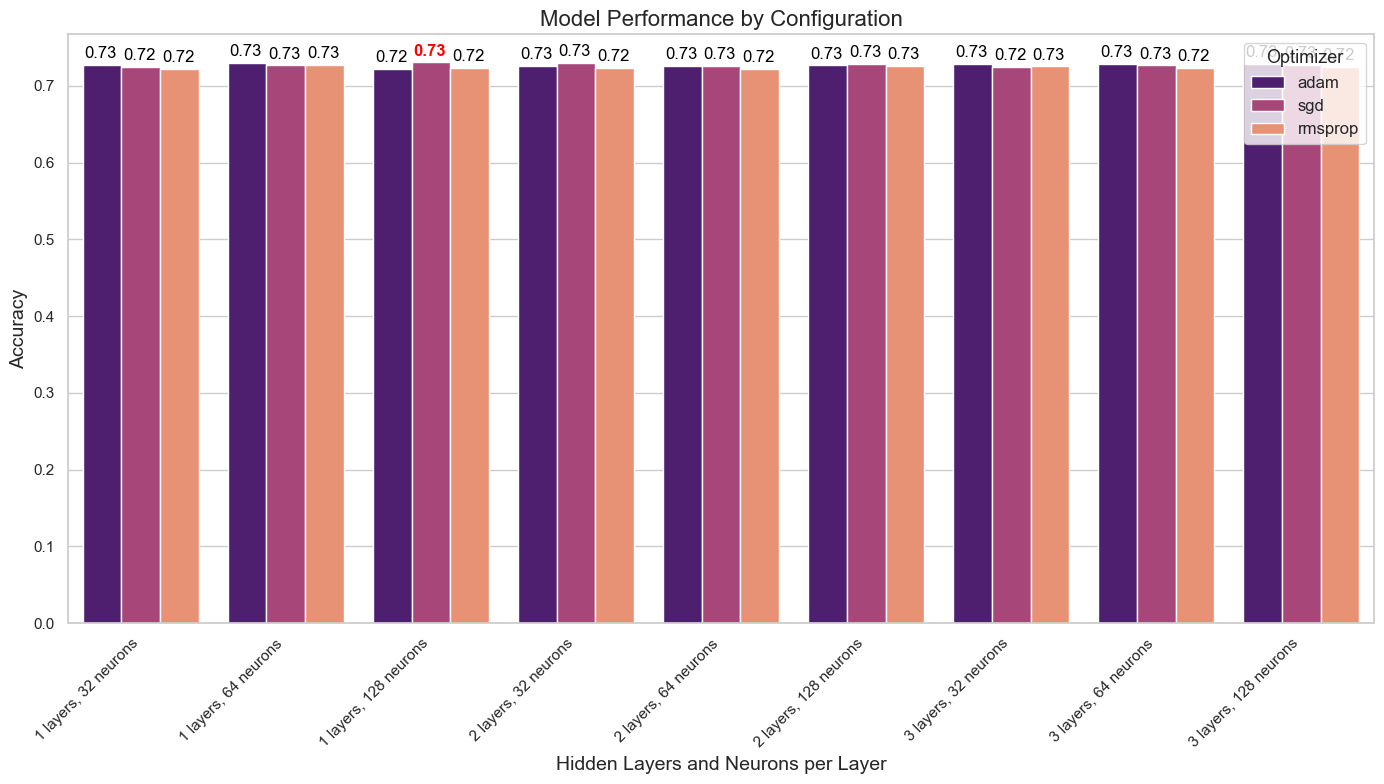

In [58]:
# Create a new column combining hidden_layers and neurons_per_layer as a string
results_df['config'] = results_df['hidden_layers'].astype(str) + ' layers, ' + results_df['neurons_per_layer'].astype(str) + ' neurons'

# Set custom style
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Create a grouped bar plot
g = sns.barplot(data=results_df, x='config', y='accuracy', hue='optimizer', palette='magma', ci=None)

# Rotate x-axis labels
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('Model Performance by Configuration', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Hidden Layers and Neurons per Layer', fontsize=14)
plt.legend(title='Optimizer', title_fontsize=13, fontsize=12)

# Add data labels on top of each bar
bar_width = 0.25
max_height = max(p.get_height() for p in g.patches)

for p in g.patches:
    label_text = format(p.get_height(), '.2f')
    text_color = 'red' if p.get_height() == max_height else 'black'
    text_weight = 'bold' if p.get_height() == max_height else 'normal'

    g.annotate(label_text,
               (p.get_x() + bar_width / 2, p.get_height()),
               ha='center', va='baseline',
               size=12,
               xytext=(0, 5),
               textcoords='offset points',
               color=text_color,
               fontweight=text_weight)

plt.tight_layout()
plt.show()


This combined plot allows us to see both the distribution of accuracy and the individual data points for each optimizer and neurons per layer configuration.

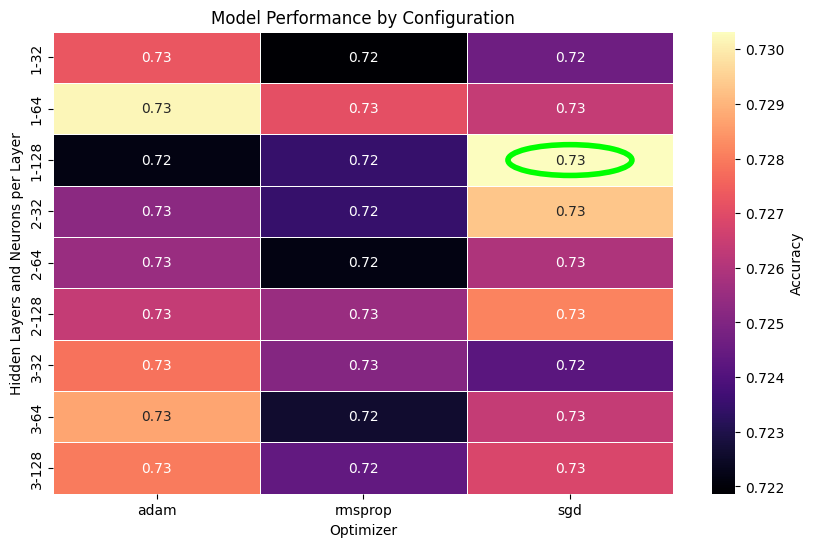

In [32]:
# Create a pivot table from the results_df DataFrame
pivot_table = results_df.pivot_table(values='accuracy', index=['hidden_layers', 'neurons_per_layer'], columns='optimizer')

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2f", linewidths=.5, cmap='magma', cbar_kws={'label': 'Accuracy'}, ax=ax)

# Find the best result
best_result_indices = np.unravel_index(np.argmax(pivot_table.to_numpy(), axis=None), pivot_table.shape)

# Calculate the best results position in the heatmap
circle_center = (best_result_indices[1] + 0.5, best_result_indices[0] + 0.5)

# Draw a red circle around the best result
circle = plt.Circle(circle_center, radius=0.3, edgecolor='lime', facecolor='none', linewidth=4)
ax.add_patch(circle)

# Set plot labels and title
ax.set_title('Model Performance by Configuration')
ax.set_xlabel('Optimizer')
ax.set_ylabel('Hidden Layers and Neurons per Layer')

plt.show()

In [16]:
# Identify the best model
best_model_index = results_df['accuracy'].idxmax()
best_model_params = results_df.loc[best_model_index]

In [59]:
# Extract the best model parameters
best_hidden_layers = int(best_model_params['hidden_layers'])
best_neurons_per_layer = int(best_model_params['neurons_per_layer'])
best_optimizer = best_model_params['optimizer']
best_loss = 0.553783
best_accuracy = 0.730321

print("Best Model Parameters:")
print(f"Hidden Layers: {best_hidden_layers}")
print(f"Neurons per Layer: {best_neurons_per_layer}")
print(f"Optimizer: {best_optimizer}")
print("\nBest Model Performance:")
print(f"Loss: {best_loss}")
print(f"Accuracy: {best_accuracy}")

Best Model Parameters:
Hidden Layers: 1
Neurons per Layer: 128
Optimizer: sgd

Best Model Performance:
Loss: 0.553783
Accuracy: 0.730321


In [60]:
# Rebuild the best model
best_model = Sequential()

In [61]:
# Add input layer
best_model.add(Dense(units=best_neurons_per_layer, activation='relu', input_dim=number_input_features))

# Add hidden layers
for _ in range(best_hidden_layers - 1):
    best_model.add(Dense(units=best_neurons_per_layer, activation='relu'))

# Add output layer
best_model.add(Dense(units=1, activation='sigmoid'))

In [62]:
# Compile the best model
best_model.compile(optimizer=best_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [63]:
# Train the best model
best_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2)

In [64]:
# Save the best model to an HDF5 file
best_model.save('AlphabetSoupCharity_Optimisation.h5')